# Future work to do

Implementing decoder, for making Long Run predictions

Use other datasets, e.g. dividends

Profiling companies and using a lot of pairs

Add convolutional layers

Apply new models. e.g. Arima,Boosting

Trying new interesting techniques, like GANs

Use Unstructured Datasets

In [1]:
%matplotlib inline
import pandas as pd
import tensorflow as tf
import numpy as np
from statsmodels.tsa.stattools import coint
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns

In [2]:
#Loading Pepsi and Coca Cola datasets
pep = pd.read_csv('data/market_data/KO.csv')
ko = pd.read_csv('data/market_data/PEP.csv')

In [3]:
#Merging the datasets
df = pd.merge(left=ko,right=pep,left_on='dt',right_on='dt')

In [4]:
#Calculating difference between lowest and highest price at that timestep for each company separately
df['x_low_high_diff'] = df.high_x - df.low_x
df['y_low_high_diff'] = df.high_y - df.low_y

In [5]:
#If I try predicting each company's stock price separately will face the problem of seasonality. 
#Thats's why I calculate ratio of a few variables between the 2 similar companies and later will try to predict the ratio's growth

df['close_ratio'] = df.close_x/df.close_y
df['open_ratio'] = df.open_x/df.open_y
df['volume_ratio'] = df.volume_x/df.volume_y
df['diff_ratio'] = df.x_low_high_diff/df.y_low_high_diff

In [6]:
df['dt'] = pd.to_datetime(df.dt)

df['month'] = df.dt.dt.month
df['year'] = df.dt.dt.year
df['dow'] = df.dt.dt.dayofweek
df['hour'] = df.dt.dt.hour

In [7]:
df['open_ratio_growth'] = 1
df['close_ratio_growth'] = 1
df['volume_ratio_growth'] = 1
df['diff_ratio_growth'] = 1 
df['open_close_ratio_growth'] = 1

df.loc[1:,'open_ratio_growth'] = np.array(df['open_ratio'].iloc[1:])/np.array(df['open_ratio'].iloc[:-1])
df.loc[1:,'close_ratio_growth'] = np.array(df['close_ratio'].iloc[1:])/np.array(df['close_ratio'].iloc[:-1])
df.loc[1:,'volume_ratio_growth'] = np.array(df['volume_ratio'].iloc[1:])/np.array(df['volume_ratio'].iloc[:-1])
df.loc[1:,'diff_ratio_growth'] = np.array(df['diff_ratio'].iloc[1:])/np.array(df['diff_ratio'].iloc[:-1])
df.loc[1:,'open_close_ratio_growth'] = np.array(df['open_ratio'].iloc[1:])/np.array(df['close_ratio'].iloc[:-1])


df['close_open_ratio_growth'] = df['close_ratio']/df['open_ratio']


df.drop(df.index[0],inplace=True,axis=0)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: divide by zero encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in true_divide
  # Remove the CWD from sys.path while we load stuff.


In [8]:
df.head()

,dt,open_x,high_x,low_x,close_x,volume_x,open_y,high_y,low_y,close_y,...,month,year,dow,hour,open_ratio_growth,close_ratio_growth,volume_ratio_growth,diff_ratio_growth,open_close_ratio_growth,close_open_ratio_growth
1,2010-01-04 10:00:00,60.710,60.980,60.70,60.951,832628,57.000,57.1100,56.90,57.01,...,1,2010,0,10,0.994941,1.003959,1.333854,0.751515,1.000165,1.003794
2,2010-01-04 10:15:00,60.950,61.099,60.87,61.055,1123591,57.005,57.1600,56.95,57.16,...,1,2010,0,10,1.003865,0.999078,0.986506,0.817857,1.000071,0.999006
3,2010-01-04 10:30:00,61.055,61.170,61.02,61.140,1387369,57.160,57.2200,57.11,57.21,...,1,2010,0,10,0.999006,1.000517,1.004114,1.250496,1.000000,1.000517
4,2010-01-04 10:45:00,61.140,61.180,61.04,61.062,1644542,57.200,57.2200,57.11,57.14,...,1,2010,0,10,1.000692,0.999948,1.036124,0.933333,1.000175,0.999773
5,2010-01-04 11:00:00,61.070,61.140,61.00,61.010,2001837,57.140,57.1685,57.05,57.09,...,1,2010,0,11,0.999904,1.000023,1.084119,0.928270,1.000131,0.999892


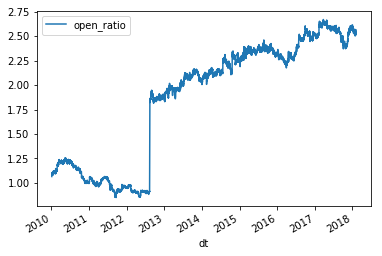

In [9]:
#Here we see artificial growth in feb 2013
df.plot(x='dt',y='open_ratio')

In [10]:
#subtract 1 from ratio_growth, so if ratio decreases, ratio_growth be negative. 
#It makes loss calculation easier and debugging, exploratory analysis more clear.  
df.loc[:,['open_ratio_growth','close_ratio_growth','open_close_ratio_growth','close_open_ratio_growth']]-=1
#because initial weights of tensorflow fully connected layers are a bit high for our target value,
#in stead of setting custom smaller weights I decided to make the target a bit larger by multiplying with 10
df.loc[:,'close_open_ratio_growth']*=10

#exploring data after artificial growth
ea_df = df[df.open_ratio>2]

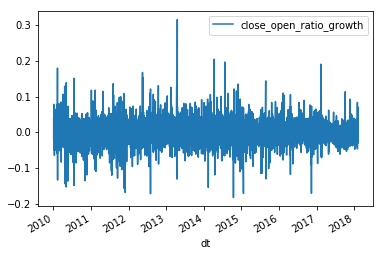

In [11]:
df.plot(x='dt',y='close_open_ratio_growth')

sns.jointplot(x="month", y="open_ratio", data=df, kind="kde", color="m")

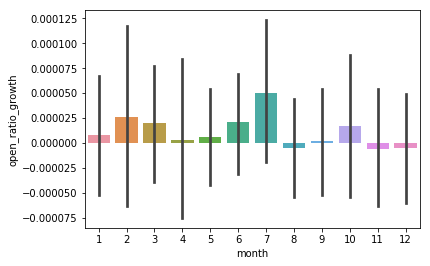

In [12]:
sns.barplot(x='month',y='open_ratio_growth',data=ea_df)

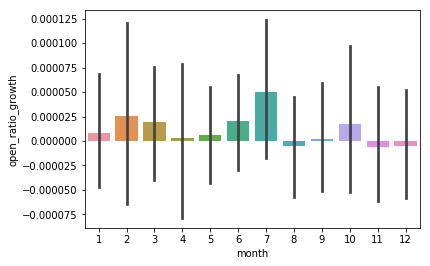

In [13]:
sns.barplot(x='month',y='open_ratio_growth',data=ea_df)

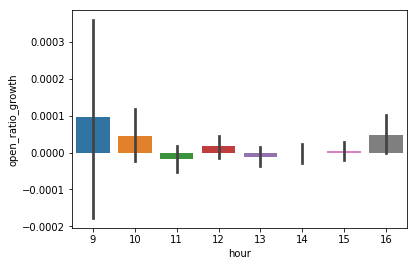

In [14]:
sns.barplot(x='hour',y='open_ratio_growth',data=ea_df)

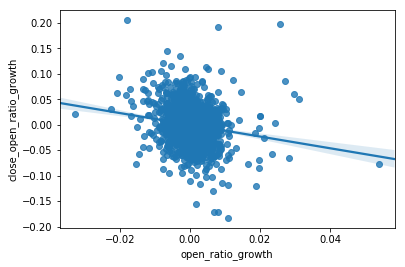

In [15]:
sns.regplot(x='open_ratio_growth',y='close_open_ratio_growth',data=ea_df)

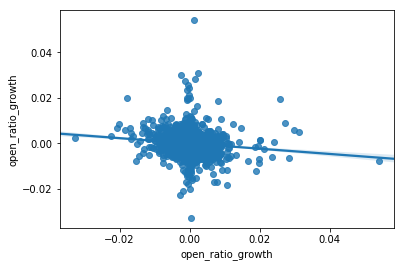

In [16]:
sns.regplot(ea_df['open_ratio_growth'].iloc[:-1],ea_df['open_ratio_growth'].iloc[1:])

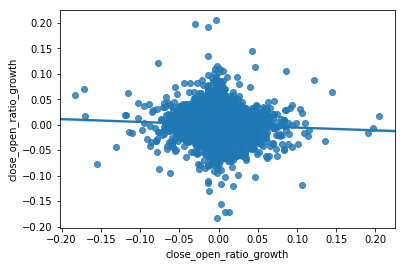

In [17]:
sns.regplot(ea_df['close_open_ratio_growth'].iloc[:-1],ea_df['close_open_ratio_growth'].iloc[1:])

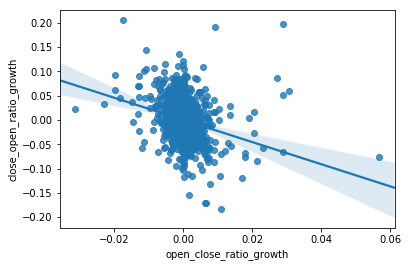

In [18]:
sns.regplot(x='open_close_ratio_growth',y='close_open_ratio_growth',data=ea_df)

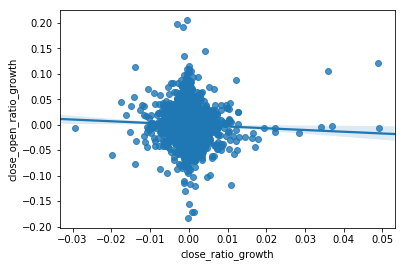

In [19]:
sns.regplot(ea_df['close_ratio_growth'].iloc[:-1],ea_df['close_open_ratio_growth'].iloc[1:])

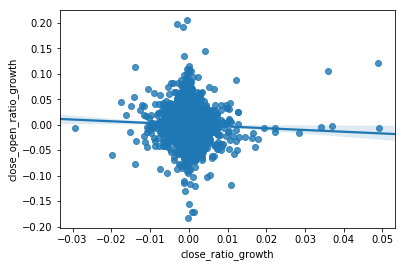

In [20]:
sns.regplot(ea_df['close_ratio_growth'].iloc[:-1],ea_df['close_open_ratio_growth'].iloc[1:])

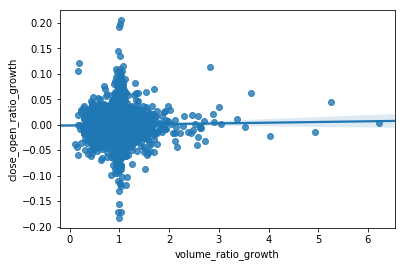

In [21]:
sns.regplot(ea_df['volume_ratio_growth'].iloc[:-1],ea_df['close_open_ratio_growth'].iloc[1:])

In [22]:
df = pd.get_dummies(df,columns=['month','year','dow','hour'])

In [23]:
#Because open and close ratios can have special behaviour in the beginning of day or week,
#I multiply ratio growths with respective dummy variables
df['org_9'] = df['open_ratio_growth']*df['hour_9'] 
df['org_0_9'] = df['open_ratio_growth']*df['hour_9']*df['dow_0'] 
df['crg_4_16'] = df['close_ratio_growth']*df['hour_16']*df['dow_4']
df['crg_16'] = df['close_ratio_growth']*df['hour_16']

In [24]:
scaler = MinMaxScaler(feature_range=(-0.5,0.5))
df[['org_9','org_0_9','high_x','low_x','high_y','low_y','close_ratio','open_close_ratio_growth','volume_ratio_growth','open_ratio','open_ratio_growth']] = scaler.fit_transform(df[['org_9','org_0_9','high_x','low_x','high_y','low_y','close_ratio','open_close_ratio_growth','volume_ratio_growth','open_ratio','open_ratio_growth']])

In [25]:
#All the features to be used to make prediction 
cols = ['org_9','org_0_9','crg_4_16','crg_16','high_x','low_x','high_y','low_y', 'month_1', 'month_2',
       'month_3', 'month_4', 'month_5', 'month_6', 'month_7', 'month_8',
       'month_9', 'month_10', 'month_11', 'month_12', 'year_2010', 'year_2011',
       'year_2012', 'year_2013', 'year_2014', 'year_2015', 'year_2016',
       'year_2017', 'dow_0', 'dow_1', 'dow_2', 'dow_3', 'dow_4', 'hour_9',
       'hour_10', 'hour_11', 'hour_12', 'hour_13', 'hour_14', 'hour_15',
       'hour_16','close_ratio','close_ratio_growth','volume_ratio_growth','open_ratio','open_ratio_growth','open_close_ratio_growth','close_open_ratio_growth']

In [26]:
batch_size = 32
#number of features
input_size = len(cols)
#number of features to be used in the time step of the target value
#As our goal is predicting close ratio growth I also use the open_ratio and open_ratio_growth of the target's time time step
last_input_size = 3
#how many timesteps to look back
num_steps = 140
num_lstm_layers = 2
lstm_size = 68
learning_rate = 0.00001
epochs = 4

data = df[cols].values

In [27]:
def build_inputs(batch_size,num_steps,input_size,last_input_size):
    inputs = tf.placeholder(shape=(batch_size,num_steps,input_size),dtype=tf.float32,name='inputs')
    #opens is the input of target's timestep
    opens = tf.placeholder(shape=(batch_size,last_input_size),dtype=tf.float32,name='opens')
    targets = tf.placeholder(shape=(batch_size,1),dtype=tf.float32,name='targets')
    
    return inputs,opens,targets

In [28]:
def build_lstm(lstm_size,num_layers,batch_size):
    
    stacked_rnn = []
    for layer in range(num_layers):
        lstm = tf.contrib.rnn.BasicLSTMCell(lstm_size)
        drop = tf.contrib.rnn.DropoutWrapper(lstm,output_keep_prob=0.7)
        stacked_rnn.append(drop)
    
    cell = tf.contrib.rnn.MultiRNNCell(cells=stacked_rnn, state_is_tuple=True)
    
    initial_state = cell.zero_state(batch_size,dtype=tf.float32)
    
    return cell, initial_state

In [29]:
def build_output(lstm_outputs,opens,in_size,out_size=1):
    last_output = lstm_outputs[:,-1,:]
    
    #MLP
    x1 = tf.contrib.layers.fully_connected(last_output,int(1.4*in_size),activation_fn=None)
    x1 = tf.layers.batch_normalization(x1)
    #leaky rely
    x1 = tf.maximum(x1,x1*0.2)
    x1 = tf.nn.dropout(x1,0.7)
    
    #in this step we concat the timeseries output we target timestep's values
    x2 = tf.contrib.layers.fully_connected(tf.concat([x1,opens],axis=1),in_size,activation_fn=None)
    x2 = tf.layers.batch_normalization(x2)
    x2 = tf.maximum(x2,x2*0.2)
    x2 = tf.nn.dropout(x2,0.7)
    
    x3 = tf.contrib.layers.fully_connected(x2,int(0.5*in_size),activation_fn=None)
    x3 = tf.layers.batch_normalization(x3)
    x3 = tf.maximum(x3,x3*0.2)
    x3 = tf.nn.dropout(x3,0.7)
    
    outputs = tf.contrib.layers.fully_connected(x3,out_size,activation_fn=None)
    
    return outputs

In [30]:
def build_loss(outputs, targets, batch_size, out_size=1):
    #simply calculating  squared difference
    loss1 = tf.reduce_mean(tf.squared_difference(outputs,targets))
    
    #calculate number of deals where predicted growth but we had decrease and vice-versa
    z = tf.reshape(tf.multiply(outputs,targets),(-1,))
    x=tf.zeros((batch_size,))
    y=tf.ones((batch_size,))
    bad_deals = tf.where(z > 0, x, y)

    loss2 = tf.multiply(tf.reduce_mean(bad_deals),0.09)
    
    
    loss = tf.add(loss1,loss2)
    
    return loss

In [31]:
class Network:
    def __init__(self,batch_size,num_steps,lstm_size,num_lstm_layers,last_input_size,input_size,learning_rate):
        tf.reset_default_graph()
        
        self.inputs,self.opens,self.targets = build_inputs(batch_size,num_steps,input_size,last_input_size)
        
        cell, self.initial_state = build_lstm(lstm_size,num_lstm_layers,batch_size)
        
        self.lstm_outputs, state = tf.nn.dynamic_rnn(cell=cell,initial_state=self.initial_state,inputs=self.inputs)
        
        self.final_state = state
        
        self.outputs = build_output(self.lstm_outputs,self.opens,lstm_size)
        
        self.loss = build_loss(self.outputs,self.targets,batch_size)
        
        self.opt = tf.train.AdamOptimizer(learning_rate).minimize(self.loss)

In [32]:
model = Network(batch_size=batch_size, num_steps=num_steps,
                lstm_size=lstm_size, num_lstm_layers=num_lstm_layers, 
                last_input_size = last_input_size, input_size=input_size,learning_rate=learning_rate)

In [33]:
def get_batch():
    l=(len(data)-num_steps*batch_size-1)//4
    #passing thru all timesteps
    for i in range(l):
                
        #collecting batch from 4 different time fields
        j = len(data)//4
        ids = list(range(i,(i+(1+num_steps)*batch_size//4))) + list(range(j,(j+(1+num_steps)*batch_size//4))) + list(range(-1*(j+(1+num_steps)*batch_size//4)-1,-j-1)) + list(range(-1*(i+(1+num_steps)*batch_size//4)-1,-i-1))
        
        batch = np.reshape(data[ids],(batch_size,num_steps+1,input_size))

        yield batch[:,:-1],batch[:,-1,-2-last_input_size:-2],batch[:,-1:,-1],(l-i)<=100#x,x_open,y,test_batch(last 100 batches are used for testing)

In [34]:
#calculating proportion of deals where we managed to correctly predict if the ratio will rise or fall
def won_deal_prop(y,y_hat):
    win_deals = sum((y_hat[:,0]*y[:,0])>0)
    return win_deals,win_deals/len(y)

In [35]:
saver = tf.train.Saver(max_to_keep=100)

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
   
    for e in range(epochs):
        
        total_train_loss,total_test_loss=0,0
        total_train_won_deals,total_test_won_deals=0,0
        
        n_train_batches=0
        n_test_batches=0
        new_state = sess.run(model.initial_state)
        
        for x, x_open, y, test_batch in get_batch():

            feed = {model.inputs: x,model.opens:x_open,
                    model.targets: y,model.initial_state:new_state
                    }
                   
            fetch = [model.loss,model.final_state,model.outputs,model.opt]
            if test_batch:
                #Last batches must be only used for testing so setting another value just to escape from optimizing 
                fetch[-1]=model.lstm_outputs
                
            batch_loss, new_state, y_hat, _ = sess.run(fetch,feed_dict=feed)
            batch_loss = batch_loss**0.5
            win_deals = sum((y_hat[:,0]*y[:,0])>0)
            win_deal_prop = win_deals/len(y)
                         
            if n_train_batches % 200 == 0 and not test_batch:
                print(e,n_train_batches,'p',y_hat[3,0],'y',y[3,0],'loss',batch_loss,'won deals',win_deal_prop)
            
            if test_batch:
                total_test_loss+= batch_loss
                total_test_won_deals+=win_deals
                n_test_batches+=1  
            else:
                total_train_loss+= batch_loss
                total_train_won_deals+=win_deals
                n_train_batches+=1  
                     
        mean_test_loss=total_test_loss/n_test_batches    
        print('Train loss',total_train_loss/n_train_batches, 'Train won deals prop',total_train_won_deals/(n_train_batches*len(y)))
        print('Test loss',mean_test_loss, 'Test won deals prop',total_test_won_deals/(n_test_batches*len(y)))
        path = 'checkpoints/e{0}_loss{1}'.format(e,mean_test_loss)
        saver.save(sess,save_path=path)

0 0 p -0.074927405 y -0.003702515756690561 loss 0.2436890736876651 won deals 0.4375
0 200 p -0.025264593 y -0.014347131701748506 loss 0.23674615034147753 won deals 0.46875
0 400 p -0.15230367 y -0.017031206902317075 loss 0.25034392065609773 won deals 0.375
0 600 p -0.057082746 y 0.008588502097726103 loss 0.23054819838978785 won deals 0.4375
0 800 p -0.030944468 y 0.00903818633727349 loss 0.21124424530125177 won deals 0.53125
0 1000 p -0.056517027 y 0.008616582182237043 loss 0.23574094100407691 won deals 0.40625
0 1200 p -0.028282791 y -0.006391184759152457 loss 0.22926906534027724 won deals 0.4375
0 1400 p -0.023208465 y 0.010302184209280973 loss 0.20240325347392626 won deals 0.5625
0 1600 p 0.024570499 y 0.01151660181007097 loss 0.20165214799769837 won deals 0.5625
0 1800 p -0.020709086 y 0.02544293624718419 loss 0.21488176356317737 won deals 0.5
0 2000 p -0.06085182 y -0.002954895426153792 loss 0.22127254421066075 won deals 0.46875
0 2200 p -0.037333556 y 0.027560540316085014 loss 0.

1 6600 p -0.0072332458 y -0.019701866885386554 loss 0.19863309982113983 won deals 0.5625
1 6800 p -0.0025937357 y -0.01740074830128613 loss 0.1680065378665356 won deals 0.6875
1 7000 p -0.0015913066 y -0.001577664504034404 loss 0.20598378701781875 won deals 0.53125
1 7200 p -0.0012342349 y 0.026251470468208193 loss 0.19885128388497544 won deals 0.5625
1 7400 p 0.0016867974 y 0.018871901112287315 loss 0.19168276179327984 won deals 0.59375
1 7600 p 0.0038356765 y 0.007482376088518983 loss 0.18413615759057955 won deals 0.625
1 7800 p 0.0039482554 y -0.0031353620282770223 loss 0.19867434634742814 won deals 0.5625
1 8000 p 0.007503395 y 0.01556590145712633 loss 0.1593798975566005 won deals 0.71875
1 8200 p -0.001193912 y -0.002621764122433534 loss 0.1838472320898649 won deals 0.625
1 8400 p 0.009190849 y -0.005576412348986537 loss 0.18404626878372518 won deals 0.625
1 8600 p 0.0013969756 y -0.005603432772492978 loss 0.19155850485638592 won deals 0.59375
1 8800 p 0.011817216 y -0.01180045594

3 800 p 0.0012939221 y 0.00903818633727349 loss 0.15049339473881573 won deals 0.75
3 1000 p 0.0031798563 y 0.008616582182237043 loss 0.1503933683368111 won deals 0.75
3 1200 p -0.005299384 y -0.006391184759152457 loss 0.191387477265564 won deals 0.59375
3 1400 p -5.4452277e-05 y 0.010302184209280973 loss 0.15943936072212955 won deals 0.71875
3 1600 p 0.0013245398 y 0.01151660181007097 loss 0.1761135668803557 won deals 0.65625
3 1800 p 0.003771665 y 0.02544293624718419 loss 0.19140711609002176 won deals 0.59375
3 2000 p -0.0042040306 y -0.002954895426153792 loss 0.14055812755660382 won deals 0.78125
3 2200 p 0.0058724005 y 0.027560540316085014 loss 0.1991302630309076 won deals 0.5625
3 2400 p 0.0040117702 y 0.0018528994743860494 loss 0.1914499194095469 won deals 0.59375
3 2600 p 0.0037815152 y -0.008830661006585805 loss 0.21235761500349123 won deals 0.5
3 2800 p -0.0017967105 y -0.002607813666223313 loss 0.16818270806985405 won deals 0.6875
3 3000 p 0.002074951 y 0.004063980316617588 lo